In [1]:
import os
import shutil
import mlflow
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import polars as pl
import re
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats

from dotenv import load_dotenv
load_dotenv("../.env")

import sys
sys.path.append("..")
from herec.utils import resultLoader

## Get Test Results

In [2]:
experiments = {experiment.experiment_id: experiment.name for experiment in mlflow.search_experiments( view_type="ACTIVE_ONLY" ) if experiment.name.endswith("-TEST")}

df_RESULT = pl.from_pandas(mlflow.search_runs( experiment_ids=experiments.keys() ))
df_RESULT = df_RESULT.select(
    pl.col("experiment_id").replace(experiments, default=None).str.split("-").list.get(0).alias("dataset_name"),
    pl.col("experiment_id").replace(experiments, default=None).str.split("-").list.get(1).alias("model_name"),
    pl.col("params.seed").cast(int),
    pl.col("^metrics(.*?)$").exclude("metrics.TRAIN_LOSS/ROUGH"),
).sort("dataset_name", "model_name")
df_RESULT = df_RESULT.with_columns( np.sqrt(pl.col("metrics.VALID_LOSS")) ) # RMSEに変換

df_RESULT

/home/sugahara/.local/lib/python3.8/site-packages/polars/series/series.py:1223: RuntimeWarning: invalid value encountered in sqrt
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


dataset_name,model_name,params.seed,metrics.BEST_VALID_LOSS,metrics.VALID_LOSS,metrics.TRAIN_LOSS,metrics.nDCG_50,metrics.HitRate_30,metrics.Precision_10,metrics.MRR_100,metrics.nDCG_100,metrics.Coverage_10,metrics.MRR_30,metrics.Precision_50,metrics.Precision_100,metrics.Recall_50,metrics.Recall_100,metrics.nDCG_30,metrics.Coverage_50,metrics.HitRate_100,metrics.Recall_10,metrics.HitRate_50,metrics.MRR_50,metrics.Recall_30,metrics.MRR_10,metrics.Coverage_100,metrics.Coverage_30,metrics.nDCG_10,metrics.HitRate_10,metrics.Precision_30
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Ciao""","""FM""",2,null,0.960782,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""FM""",1,null,0.942458,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""FM""",0,null,1.011424,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_FM""",2,null,0.94985,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_FM""",1,null,0.936802,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_FM""",0,null,0.999538,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_MF""",2,null,0.962832,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_MF""",1,null,0.93599,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Ciao""","""HE_MF""",0,null,0.995068,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


## Common

In [3]:
def getTestResults( datasetNameList, modelNameList, seedList, metricMap ):

    df_TARGET = df_RESULT.filter(
        pl.col("dataset_name").is_in(datasetNameList)
        & pl.col("model_name").is_in(modelNameList)
        & pl.col("params.seed").is_in(seedList)
    ).select(
        [pl.all().exclude("^metrics(.*?)$")] + [pl.col(f"metrics.{old_name}").alias(new_name) for old_name, new_name in metricMap.items()]
    )

    if "RMSE" in df_TARGET.columns:
        df_TARGET = df_TARGET.with_columns( np.sqrt(pl.col("RMSE")) )
    
    df_MEAN = df_TARGET.to_pandas().groupby(["dataset_name", "model_name"]).mean().reset_index()
    df_MEAN = df_MEAN.pivot_table( values=metricMap.values(), index="model_name", columns="dataset_name" ).swaplevel(axis=1)
    df_MEAN = df_MEAN.loc[modelNameList, [(datasetName, metricName) for datasetName in datasetNameList for metricName in metricMap.values()]]
    
    df_STD = df_TARGET.to_pandas().groupby(["dataset_name", "model_name"]).std().reset_index().fillna(-np.inf)
    df_STD = df_STD.pivot_table( values=metricMap.values(), index="model_name", columns="dataset_name" ).swaplevel(axis=1)
    df_STD = df_STD.loc[modelNameList, [(datasetName, metricName) for datasetName in datasetNameList for metricName in metricMap.values()]]
    
    df_COUNT = df_TARGET.to_pandas().groupby(["dataset_name", "model_name"]).count().reset_index()
    df_COUNT = df_COUNT.pivot_table( values=metricMap.values(), index="model_name", columns="dataset_name" ).swaplevel(axis=1)
    df_COUNT = df_COUNT.loc[modelNameList, [(datasetName, metricName) for datasetName in datasetNameList for metricName in metricMap.values()]]

    df_STATS = df_TARGET.group_by(["dataset_name", "model_name"]).agg( pl.all() ).drop("params.seed").to_pandas().set_index(["dataset_name", "model_name"])
    df_STATS = df_STATS.loc[[(datasetName, modelName) for datasetName in datasetNameList for modelName in modelNameList]]
    for columnName in metricMap.values():
        for i in reversed(range(df_STATS.shape[0])):
            df_STATS[columnName].iloc[i] = stats.ttest_rel(df_STATS[columnName].iloc[i], df_STATS[columnName].iloc[0]).pvalue
    df_STATS = df_STATS.fillna(np.inf)
    df_STATS = df_STATS.pivot_table( values=metricMap.values(), index="model_name", columns="dataset_name" ).swaplevel(axis=1)
    df_STATS = df_STATS.loc[modelNameList, [(datasetName, metricName) for datasetName in datasetNameList for metricName in metricMap.values()]]
    
    return df_MEAN, df_STD, df_COUNT.astype(int), df_STATS

In [4]:
def bar_visualize( df_MEAN, df_COUNT ):

    for (datasetName, metricName), modelName in df_MEAN.T.iterrows():
        
        fig, ax = plt.subplots( figsize=(3, 2) )
    
        labels = modelName.index[::-1]
        values = modelName.values[::-1]
        bar = ax.barh( labels, values, color=np.where(modelName.index.str.contains("HE")[::-1], "black", "gray") )
        ax.bar_label(bar, labels=values.round(3))
        ax.set_xlabel( "Model" )
        ax.set_ylabel( metricName )
        
        plt.suptitle( datasetName )
        plt.show()

In [5]:
def k_wise_visualize( df_MEAN, df_COUNT ):

    df_COUNT = df_COUNT.T.groupby(level=0).max().T

    # データセットのユニークリスト
    datasetNameList = df_MEAN.columns.get_level_values(0).unique()
    
    for datasetName in datasetNameList:
    
        # 対象データセットの結果を抽出
        df = df_MEAN[datasetName]
        
        # 評価指標のユニークリスト
        metricNameList = df.columns.str.replace("@\d+", "", regex=True).unique()
    
        # matplotlibの初期化
        fig, axes = plt.subplots(1, len(metricNameList), figsize=(3*len(metricNameList), 3))
        
        for i, metricName in enumerate(metricNameList):
    
            # 対象評価指標データセットの結果を抽出
            df2 = df.loc[ :, df.columns.str.startswith(metricName) ]
            df2.columns = df2.columns.str.replace(f"{metricName}@", "")
            
            for j, (modelName, scores) in enumerate(df2.iterrows()):
                (axes[i] if len(metricNameList) > 1 else axes).plot(scores.index, scores.values, linewidth=0.5, linestyle="dashed", marker=list(matplotlib.lines.Line2D.markers)[j+2], markersize=8, fillstyle="none", label=f"{modelName} ({df_COUNT.loc[modelName, datasetName]})" )
            
            axes[i].set_xlabel("$k$")
            axes[i].set_ylabel(metricName)
            # axes[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        
        print(datasetName)
        plt.suptitle( datasetName )
        axes[-1].legend( bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0 )
        # plt.tight_layout()
        plt.subplots_adjust(wspace=0.4)
        plt.show()

In [6]:
def to_latex( df_MEAN, df_STD, ascending=True ):

    df_PREFIX = np.where( df_MEAN.rank(axis=0, ascending=ascending) == 1, "\\textbf{", "{" )
    df_PREFIX = np.where( df_MEAN.rank(axis=0, ascending=ascending) == 2, "\\uline{", df_PREFIX )
    # df_PREFIX = np.where( df_MEAN.rank(axis=0, ascending=ascending) == 3, "\\dashuline{", df_PREFIX )
    df_SUFFIX = np.where( df_MEAN.rank(axis=0, ascending=ascending) == 1, "}", "}" )
    df_LATEX = df_PREFIX + df_MEAN.applymap( lambda s: '{:.3f}'.format(s) ) + " $\pm$ " + df_STD.applymap( lambda s: '{:.3f}'.format(s) ) + df_SUFFIX
    df_LATEX.index.name = None
    df_LATEX.columns.names = (None, None)

    display(df_LATEX)
    print(df_LATEX.to_latex())

## ExplicitDataset

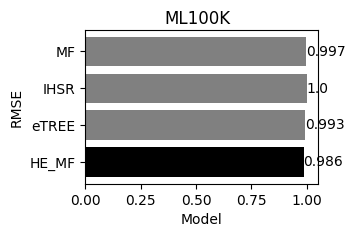

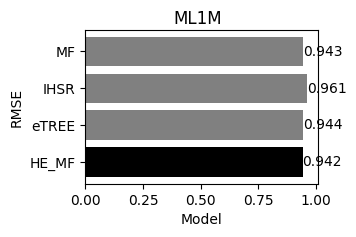

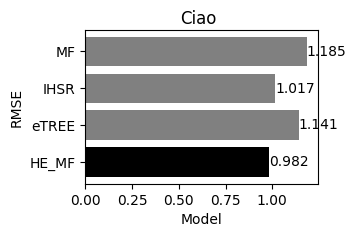

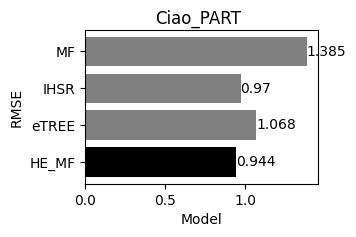

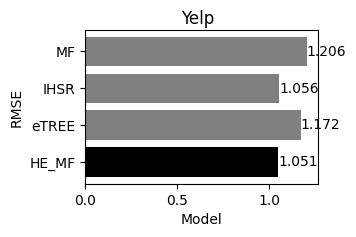

,ML100K,ML1M,Ciao,Ciao_PART,Yelp
,RMSE,RMSE,RMSE,RMSE,RMSE
MF,{0.997 $\pm$ 0.026},\uline{0.943 $\pm$ 0.007},{1.185 $\pm$ 0.008},{1.385 $\pm$ 0.059},{1.206 $\pm$ 0.020}
IHSR,{1.000 $\pm$ 0.025},{0.961 $\pm$ 0.018},\uline{1.017 $\pm$ 0.017},\uline{0.970 $\pm$ 0.024},\uline{1.056 $\pm$ 0.020}
eTREE,\uline{0.993 $\pm$ 0.025},{0.944 $\pm$ 0.017},{1.141 $\pm$ 0.076},{1.068 $\pm$ 0.017},{1.172 $\pm$ 0.015}
HE_MF,\textbf{0.986 $\pm$ 0.007},\textbf{0.942 $\pm$ 0.011},\textbf{0.982 $\pm$ 0.015},\textbf{0.944 $\pm$ 0.022},\textbf{1.051 $\pm$ 0.018}


\begin{tabular}{llllll}
\toprule
 & ML100K & ML1M & Ciao & Ciao_PART & Yelp \\
 & RMSE & RMSE & RMSE & RMSE & RMSE \\
\midrule
MF & {0.997 $\pm$ 0.026} & \uline{0.943 $\pm$ 0.007} & {1.185 $\pm$ 0.008} & {1.385 $\pm$ 0.059} & {1.206 $\pm$ 0.020} \\
IHSR & {1.000 $\pm$ 0.025} & {0.961 $\pm$ 0.018} & \uline{1.017 $\pm$ 0.017} & \uline{0.970 $\pm$ 0.024} & \uline{1.056 $\pm$ 0.020} \\
eTREE & \uline{0.993 $\pm$ 0.025} & {0.944 $\pm$ 0.017} & {1.141 $\pm$ 0.076} & {1.068 $\pm$ 0.017} & {1.172 $\pm$ 0.015} \\
HE_MF & \textbf{0.986 $\pm$ 0.007} & \textbf{0.942 $\pm$ 0.011} & \textbf{0.982 $\pm$ 0.015} & \textbf{0.944 $\pm$ 0.022} & \textbf{1.051 $\pm$ 0.018} \\
\bottomrule
\end{tabular}



dataset_name,ML100K,ML1M,Ciao,Ciao_PART,Yelp
,RMSE,RMSE,RMSE,RMSE,RMSE
model_name,,,,,
MF,3,3,3,3,3
IHSR,3,3,3,3,3
eTREE,3,3,3,3,3
HE_MF,3,3,3,3,3


In [7]:
df_MEAN, df_STD, df_COUNT, df_STATS = getTestResults(
    datasetNameList = ["ML100K", "ML1M", "Ciao", "Ciao_PART", "Yelp"],
    modelNameList = ["MF", "IHSR", "eTREE", "HE_MF"],
    seedList = range(3),
    metricMap = {"VALID_LOSS": "RMSE"},
)

bar_visualize( df_MEAN, df_COUNT )
to_latex( df_MEAN, df_STD )
display(df_COUNT)

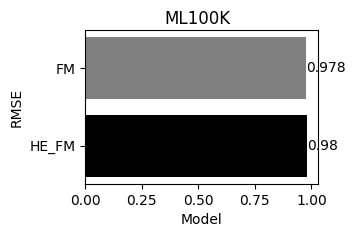

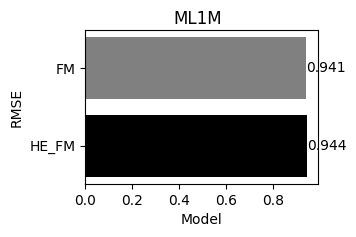

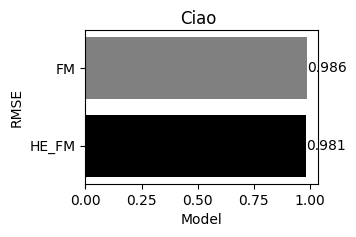

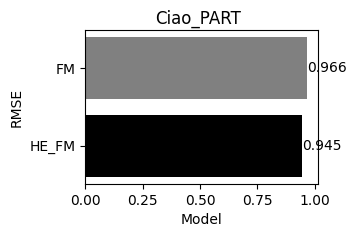

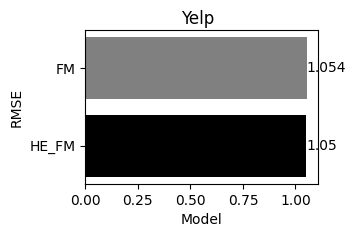

,ML100K,ML1M,Ciao,Ciao_PART,Yelp
,RMSE,RMSE,RMSE,RMSE,RMSE
FM,\textbf{0.978 $\pm$ 0.005},\textbf{0.941 $\pm$ 0.009},\uline{0.986 $\pm$ 0.018},\uline{0.966 $\pm$ 0.010},\uline{1.054 $\pm$ 0.019}
HE_FM,\uline{0.980 $\pm$ 0.009},\uline{0.944 $\pm$ 0.011},\textbf{0.981 $\pm$ 0.017},\textbf{0.945 $\pm$ 0.017},\textbf{1.050 $\pm$ 0.018}


\begin{tabular}{llllll}
\toprule
 & ML100K & ML1M & Ciao & Ciao_PART & Yelp \\
 & RMSE & RMSE & RMSE & RMSE & RMSE \\
\midrule
FM & \textbf{0.978 $\pm$ 0.005} & \textbf{0.941 $\pm$ 0.009} & \uline{0.986 $\pm$ 0.018} & \uline{0.966 $\pm$ 0.010} & \uline{1.054 $\pm$ 0.019} \\
HE_FM & \uline{0.980 $\pm$ 0.009} & \uline{0.944 $\pm$ 0.011} & \textbf{0.981 $\pm$ 0.017} & \textbf{0.945 $\pm$ 0.017} & \textbf{1.050 $\pm$ 0.018} \\
\bottomrule
\end{tabular}



dataset_name,ML100K,ML1M,Ciao,Ciao_PART,Yelp
,RMSE,RMSE,RMSE,RMSE,RMSE
model_name,,,,,
FM,3,3,3,3,3
HE_FM,3,3,3,3,3


In [8]:
df_MEAN, df_STD, df_COUNT, df_STATS = getTestResults(
    datasetNameList = ["ML100K", "ML1M", "Ciao", "Ciao_PART", "Yelp"],
    modelNameList = ["FM", "HE_FM"],
    seedList = range(3),
    metricMap = {"VALID_LOSS": "RMSE"},
)

bar_visualize( df_MEAN, df_COUNT )
to_latex( df_MEAN, df_STD )
display(df_COUNT)

## ImplicitDataset

In [9]:
datasetNameList = ["ML100K_IMPLICIT"]

df_MEAN, df_STD, df_COUNT, df_STATS = getTestResults(
    datasetNameList = datasetNameList,
    modelNameList = ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR"],
    seedList = range(3),
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["HitRate", "Recall", "nDCG"] for k in [10] },
)
to_latex(df_MEAN, df_STD, False)
display(df_COUNT)

df_MEAN, df_STD, df_COUNT, df_STATS = getTestResults(
    datasetNameList = datasetNameList,
    modelNameList = ["NeuMF_BPR", "HE_NeuMF_BPR"],
    seedList = range(3),
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["HitRate", "Recall", "nDCG"] for k in [10] },
)
to_latex(df_MEAN, df_STD, False)
display(df_COUNT)

ML100K_IMPLICIT                              \
                                HitRate@10                   Recall@10   
MF_BPR           \uline{0.215 $\pm$ 0.065}         {0.027 $\pm$ 0.012}   
ProtoMF_BPR            {0.210 $\pm$ 0.166}   \uline{0.030 $\pm$ 0.025}   
HE_MF_USER_BPR  \textbf{0.233 $\pm$ 0.020}  \textbf{0.030 $\pm$ 0.008}   
HE_MF_ITEM_BPR         {0.209 $\pm$ 0.053}         {0.022 $\pm$ 0.008}   
HE_MF_BPR              {0.197 $\pm$ 0.093}         {0.020 $\pm$ 0.013}   

                                            
                                   nDCG@10  
MF_BPR           \uline{0.047 $\pm$ 0.021}  
ProtoMF_BPR            {0.043 $\pm$ 0.039}  
HE_MF_USER_BPR  \textbf{0.049 $\pm$ 0.012}  
HE_MF_ITEM_BPR         {0.044 $\pm$ 0.008}  
HE_MF_BPR              {0.041 $\pm$ 0.032}

\begin{tabular}{llll}
\toprule
 & \multicolumn{3}{r}{ML100K_IMPLICIT} \\
 & HitRate@10 & Recall@10 & nDCG@10 \\
\midrule
MF_BPR & \uline{0.215 $\pm$ 0.065} & {0.027 $\pm$ 0.012} & \uline{0.047 $\pm$ 0.021} \\
ProtoMF_BPR & {0.210 $\pm$ 0.166} & \uline{0.030 $\pm$ 0.025} & {0.043 $\pm$ 0.039} \\
HE_MF_USER_BPR & \textbf{0.233 $\pm$ 0.020} & \textbf{0.030 $\pm$ 0.008} & \textbf{0.049 $\pm$ 0.012} \\
HE_MF_ITEM_BPR & {0.209 $\pm$ 0.053} & {0.022 $\pm$ 0.008} & {0.044 $\pm$ 0.008} \\
HE_MF_BPR & {0.197 $\pm$ 0.093} & {0.020 $\pm$ 0.013} & {0.041 $\pm$ 0.032} \\
\bottomrule
\end{tabular}



dataset_name   ML100K_IMPLICIT                  
                    HitRate@10 Recall@10 nDCG@10
model_name                                      
MF_BPR                       3         3       3
ProtoMF_BPR                  3         3       3
HE_MF_USER_BPR               3         3       3
HE_MF_ITEM_BPR               3         3       3
HE_MF_BPR                    3         3       3

ML100K_IMPLICIT                              \
                              HitRate@10                   Recall@10   
NeuMF_BPR      \uline{0.202 $\pm$ 0.020}   \uline{0.020 $\pm$ 0.006}   
HE_NeuMF_BPR  \textbf{0.243 $\pm$ 0.066}  \textbf{0.039 $\pm$ 0.020}   

                                          
                                 nDCG@10  
NeuMF_BPR      \uline{0.045 $\pm$ 0.005}  
HE_NeuMF_BPR  \textbf{0.058 $\pm$ 0.032}

\begin{tabular}{llll}
\toprule
 & \multicolumn{3}{r}{ML100K_IMPLICIT} \\
 & HitRate@10 & Recall@10 & nDCG@10 \\
\midrule
NeuMF_BPR & \uline{0.202 $\pm$ 0.020} & \uline{0.020 $\pm$ 0.006} & \uline{0.045 $\pm$ 0.005} \\
HE_NeuMF_BPR & \textbf{0.243 $\pm$ 0.066} & \textbf{0.039 $\pm$ 0.020} & \textbf{0.058 $\pm$ 0.032} \\
\bottomrule
\end{tabular}



dataset_name ML100K_IMPLICIT                  
                  HitRate@10 Recall@10 nDCG@10
model_name                                    
NeuMF_BPR                  3         3       3
HE_NeuMF_BPR               3         3       3

In [10]:
datasetNameList = ["ML1M_IMPLICIT"]

df_MEAN, df_STD, df_COUNT, df_STATS = getTestResults(
    datasetNameList = datasetNameList,
    modelNameList = ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR"],
    seedList = range(3),
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["HitRate", "Recall", "nDCG"] for k in [10] },
)
to_latex(df_MEAN, df_STD, False)
display(df_COUNT)

df_MEAN, df_STD, df_COUNT, df_STATS = getTestResults(
    datasetNameList = datasetNameList,
    modelNameList = ["NeuMF_BPR", "HE_NeuMF_BPR"],
    seedList = range(3),
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["HitRate", "Recall", "nDCG"] for k in [10] },
)
to_latex(df_MEAN, df_STD, False)
display(df_COUNT)

ML1M_IMPLICIT                              \
                                HitRate@10                   Recall@10   
MF_BPR                 {0.333 $\pm$ 0.079}         {0.023 $\pm$ 0.008}   
ProtoMF_BPR     \textbf{0.350 $\pm$ 0.076}   \uline{0.026 $\pm$ 0.007}   
HE_MF_USER_BPR         {0.340 $\pm$ 0.087}         {0.025 $\pm$ 0.010}   
HE_MF_ITEM_BPR   \uline{0.340 $\pm$ 0.080}  \textbf{0.027 $\pm$ 0.006}   
HE_MF_BPR              {0.336 $\pm$ 0.072}         {0.026 $\pm$ 0.003}   

                                            
                                   nDCG@10  
MF_BPR                 {0.072 $\pm$ 0.022}  
ProtoMF_BPR     \textbf{0.079 $\pm$ 0.021}  
HE_MF_USER_BPR         {0.077 $\pm$ 0.027}  
HE_MF_ITEM_BPR   \uline{0.078 $\pm$ 0.023}  
HE_MF_BPR              {0.076 $\pm$ 0.016}

\begin{tabular}{llll}
\toprule
 & \multicolumn{3}{r}{ML1M_IMPLICIT} \\
 & HitRate@10 & Recall@10 & nDCG@10 \\
\midrule
MF_BPR & {0.333 $\pm$ 0.079} & {0.023 $\pm$ 0.008} & {0.072 $\pm$ 0.022} \\
ProtoMF_BPR & \textbf{0.350 $\pm$ 0.076} & \uline{0.026 $\pm$ 0.007} & \textbf{0.079 $\pm$ 0.021} \\
HE_MF_USER_BPR & {0.340 $\pm$ 0.087} & {0.025 $\pm$ 0.010} & {0.077 $\pm$ 0.027} \\
HE_MF_ITEM_BPR & \uline{0.340 $\pm$ 0.080} & \textbf{0.027 $\pm$ 0.006} & \uline{0.078 $\pm$ 0.023} \\
HE_MF_BPR & {0.336 $\pm$ 0.072} & {0.026 $\pm$ 0.003} & {0.076 $\pm$ 0.016} \\
\bottomrule
\end{tabular}



dataset_name   ML1M_IMPLICIT                  
                  HitRate@10 Recall@10 nDCG@10
model_name                                    
MF_BPR                     3         3       3
ProtoMF_BPR                3         3       3
HE_MF_USER_BPR             3         3       3
HE_MF_ITEM_BPR             3         3       3
HE_MF_BPR                  3         3       3

ML1M_IMPLICIT                              \
                              HitRate@10                   Recall@10   
NeuMF_BPR     \textbf{0.336 $\pm$ 0.066}   \uline{0.025 $\pm$ 0.003}   
HE_NeuMF_BPR   \uline{0.324 $\pm$ 0.064}  \textbf{0.025 $\pm$ 0.003}   

                                          
                                 nDCG@10  
NeuMF_BPR     \textbf{0.073 $\pm$ 0.011}  
HE_NeuMF_BPR   \uline{0.070 $\pm$ 0.012}

\begin{tabular}{llll}
\toprule
 & \multicolumn{3}{r}{ML1M_IMPLICIT} \\
 & HitRate@10 & Recall@10 & nDCG@10 \\
\midrule
NeuMF_BPR & \textbf{0.336 $\pm$ 0.066} & \uline{0.025 $\pm$ 0.003} & \textbf{0.073 $\pm$ 0.011} \\
HE_NeuMF_BPR & \uline{0.324 $\pm$ 0.064} & \textbf{0.025 $\pm$ 0.003} & \uline{0.070 $\pm$ 0.012} \\
\bottomrule
\end{tabular}



dataset_name ML1M_IMPLICIT                  
                HitRate@10 Recall@10 nDCG@10
model_name                                  
NeuMF_BPR                3         3       3
HE_NeuMF_BPR             3         3       3

In [11]:
datasetNameList = ["Twitch100K"]

df_MEAN, df_STD, df_COUNT, df_STATS = getTestResults(
    datasetNameList = datasetNameList,
    modelNameList = ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR"],
    seedList = range(3),
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["HitRate", "Recall", "nDCG"] for k in [10] },
)
to_latex(df_MEAN, df_STD, False)
display(df_COUNT)

Twitch100K                              \
                                HitRate@10                   Recall@10   
MF_BPR          \textbf{0.258 $\pm$ 0.008}  \textbf{0.189 $\pm$ 0.007}   
ProtoMF_BPR            {0.188 $\pm$ 0.018}         {0.132 $\pm$ 0.015}   
HE_MF_USER_BPR         {0.237 $\pm$ 0.024}         {0.172 $\pm$ 0.017}   
HE_MF_ITEM_BPR   \uline{0.257 $\pm$ 0.015}   \uline{0.187 $\pm$ 0.011}   
HE_MF_BPR              {0.219 $\pm$ 0.027}         {0.158 $\pm$ 0.019}   

                                            
                                   nDCG@10  
MF_BPR           \uline{0.100 $\pm$ 0.008}  
ProtoMF_BPR            {0.074 $\pm$ 0.009}  
HE_MF_USER_BPR         {0.095 $\pm$ 0.011}  
HE_MF_ITEM_BPR  \textbf{0.104 $\pm$ 0.010}  
HE_MF_BPR              {0.087 $\pm$ 0.011}

\begin{tabular}{llll}
\toprule
 & \multicolumn{3}{r}{Twitch100K} \\
 & HitRate@10 & Recall@10 & nDCG@10 \\
\midrule
MF_BPR & \textbf{0.258 $\pm$ 0.008} & \textbf{0.189 $\pm$ 0.007} & \uline{0.100 $\pm$ 0.008} \\
ProtoMF_BPR & {0.188 $\pm$ 0.018} & {0.132 $\pm$ 0.015} & {0.074 $\pm$ 0.009} \\
HE_MF_USER_BPR & {0.237 $\pm$ 0.024} & {0.172 $\pm$ 0.017} & {0.095 $\pm$ 0.011} \\
HE_MF_ITEM_BPR & \uline{0.257 $\pm$ 0.015} & \uline{0.187 $\pm$ 0.011} & \textbf{0.104 $\pm$ 0.010} \\
HE_MF_BPR & {0.219 $\pm$ 0.027} & {0.158 $\pm$ 0.019} & {0.087 $\pm$ 0.011} \\
\bottomrule
\end{tabular}



dataset_name   Twitch100K                  
               HitRate@10 Recall@10 nDCG@10
model_name                                 
MF_BPR                  3         3       3
ProtoMF_BPR             3         3       3
HE_MF_USER_BPR          3         3       3
HE_MF_ITEM_BPR          3         3       3
HE_MF_BPR               3         3       3

In [12]:
datasetNameList = ["FourSquare"]

df_MEAN, df_STD, df_COUNT, df_STATS = getTestResults(
    datasetNameList = datasetNameList,
    modelNameList = ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR"],
    seedList = range(3),
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["HitRate", "Recall", "nDCG"] for k in [10] },
)
to_latex(df_MEAN, df_STD, False)
display(df_COUNT)

df_MEAN, df_STD, df_COUNT, df_STATS = getTestResults(
    datasetNameList = datasetNameList,
    modelNameList = ["NeuMF_BPR", "HE_NeuMF_BPR"],
    seedList = range(3),
    metricMap = { f"{metricName}_{k}": f"{metricName}@{k}" for metricName in ["HitRate", "Recall", "nDCG"] for k in [10] },
)
to_latex(df_MEAN, df_STD, False)
display(df_COUNT)

FourSquare                              \
                                HitRate@10                   Recall@10   
MF_BPR          \textbf{0.212 $\pm$ 0.041}  \textbf{0.032 $\pm$ 0.005}   
ProtoMF_BPR      \uline{0.212 $\pm$ 0.036}   \uline{0.032 $\pm$ 0.004}   
HE_MF_USER_BPR         {0.209 $\pm$ 0.037}         {0.030 $\pm$ 0.005}   
HE_MF_ITEM_BPR         {0.198 $\pm$ 0.036}         {0.030 $\pm$ 0.004}   
HE_MF_BPR              {0.195 $\pm$ 0.021}         {0.028 $\pm$ 0.001}   

                                            
                                   nDCG@10  
MF_BPR           \uline{0.034 $\pm$ 0.005}  
ProtoMF_BPR     \textbf{0.036 $\pm$ 0.005}  
HE_MF_USER_BPR         {0.033 $\pm$ 0.004}  
HE_MF_ITEM_BPR         {0.032 $\pm$ 0.004}  
HE_MF_BPR              {0.032 $\pm$ 0.002}

\begin{tabular}{llll}
\toprule
 & \multicolumn{3}{r}{FourSquare} \\
 & HitRate@10 & Recall@10 & nDCG@10 \\
\midrule
MF_BPR & \textbf{0.212 $\pm$ 0.041} & \textbf{0.032 $\pm$ 0.005} & \uline{0.034 $\pm$ 0.005} \\
ProtoMF_BPR & \uline{0.212 $\pm$ 0.036} & \uline{0.032 $\pm$ 0.004} & \textbf{0.036 $\pm$ 0.005} \\
HE_MF_USER_BPR & {0.209 $\pm$ 0.037} & {0.030 $\pm$ 0.005} & {0.033 $\pm$ 0.004} \\
HE_MF_ITEM_BPR & {0.198 $\pm$ 0.036} & {0.030 $\pm$ 0.004} & {0.032 $\pm$ 0.004} \\
HE_MF_BPR & {0.195 $\pm$ 0.021} & {0.028 $\pm$ 0.001} & {0.032 $\pm$ 0.002} \\
\bottomrule
\end{tabular}



dataset_name   FourSquare                  
               HitRate@10 Recall@10 nDCG@10
model_name                                 
MF_BPR                  3         3       3
ProtoMF_BPR             3         3       3
HE_MF_USER_BPR          3         3       3
HE_MF_ITEM_BPR          3         3       3
HE_MF_BPR               3         3       3

FourSquare                              \
                              HitRate@10                   Recall@10   
NeuMF_BPR     \textbf{0.210 $\pm$ 0.041}  \textbf{0.031 $\pm$ 0.005}   
HE_NeuMF_BPR   \uline{0.202 $\pm$ 0.028}   \uline{0.030 $\pm$ 0.002}   

                                          
                                 nDCG@10  
NeuMF_BPR     \textbf{0.034 $\pm$ 0.005}  
HE_NeuMF_BPR   \uline{0.033 $\pm$ 0.003}

\begin{tabular}{llll}
\toprule
 & \multicolumn{3}{r}{FourSquare} \\
 & HitRate@10 & Recall@10 & nDCG@10 \\
\midrule
NeuMF_BPR & \textbf{0.210 $\pm$ 0.041} & \textbf{0.031 $\pm$ 0.005} & \textbf{0.034 $\pm$ 0.005} \\
HE_NeuMF_BPR & \uline{0.202 $\pm$ 0.028} & \uline{0.030 $\pm$ 0.002} & \uline{0.033 $\pm$ 0.003} \\
\bottomrule
\end{tabular}



dataset_name FourSquare                  
             HitRate@10 Recall@10 nDCG@10
model_name                               
NeuMF_BPR             3         3       3
HE_NeuMF_BPR          3         3       3